In [139]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [1]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [12]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(0, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

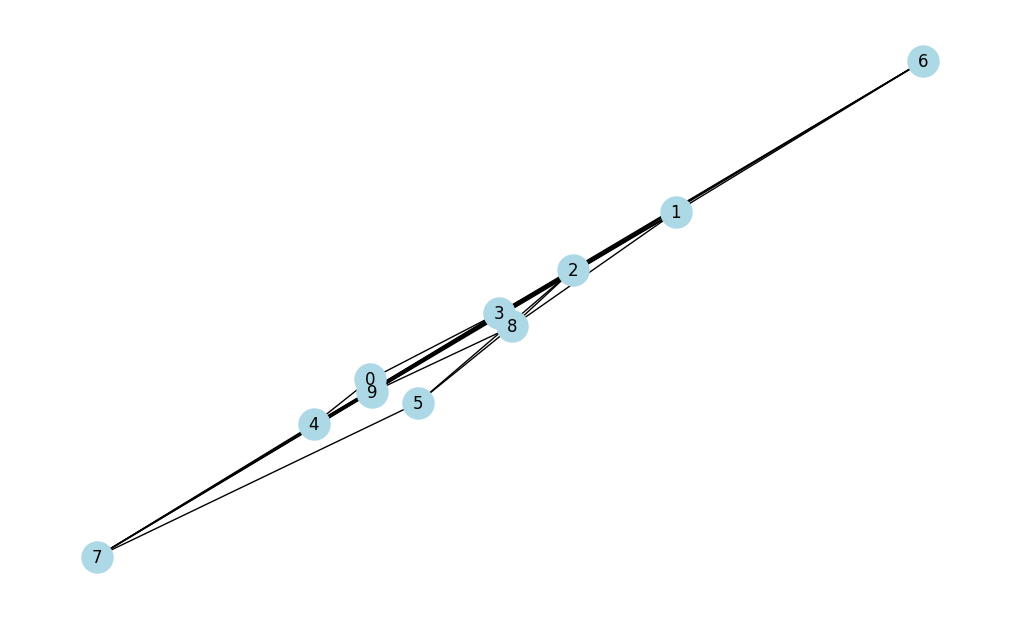

In [142]:
G = gnp_random_connected_graph(10, 0.5, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [143]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

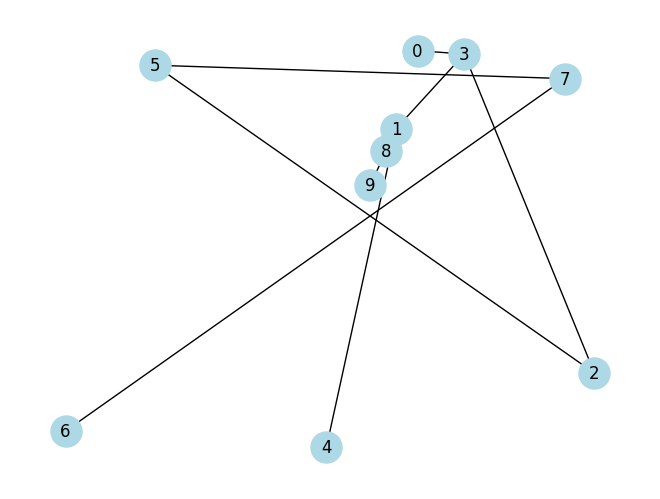

In [144]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [145]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 3), (1, 4), (1, 3), (1, 8), (2, 3), (2, 5), (5, 7), (6, 7), (8, 9)]),
 9)

*put your code below* (delete this)

### Prim's algorithm

In [146]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

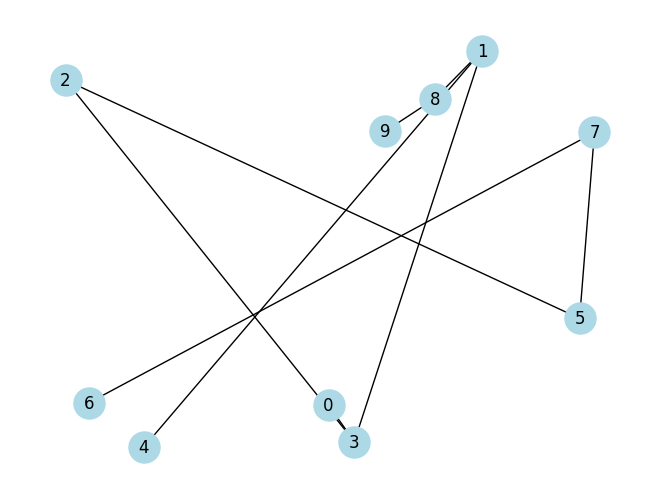

In [147]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [148]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 3), (1, 3), (1, 4), (1, 8), (2, 3), (2, 5), (5, 7), (6, 7), (8, 9)]),
 9)

*put your code below* (delete this)

## Subtask 1.2

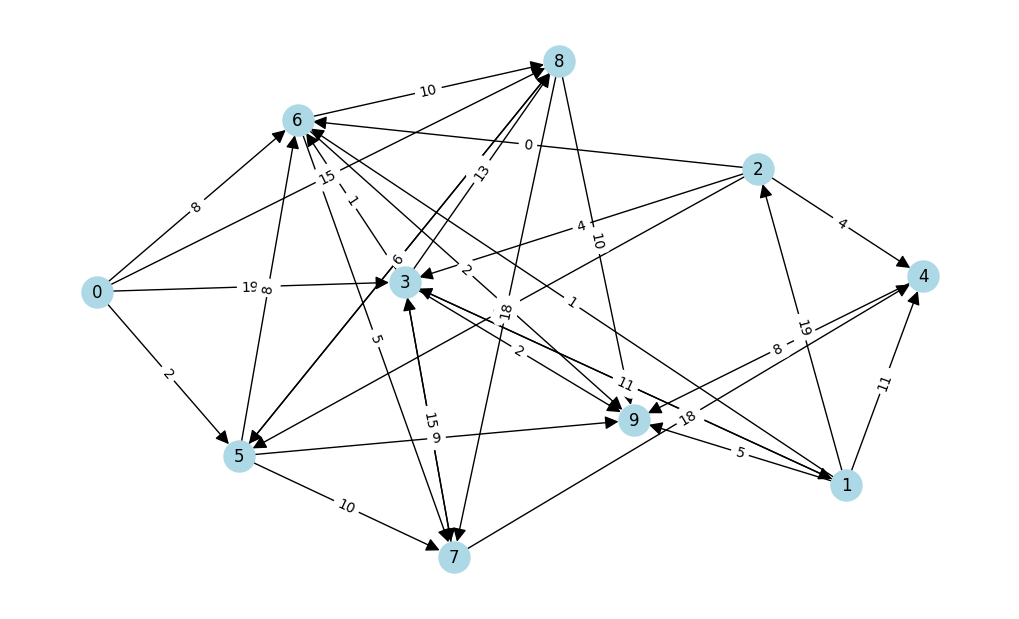

In [8]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### NetworkX Bellman-Ford algorithm

In [150]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


### Our Bellman-Ford alogirthm

In [3]:
def bellman_ford(graph, start: int):
    nodes = list(graph.nodes)
    adj = dict(graph.adjacency())

    dists = {vertex: float('inf') for vertex in nodes}
    dists[start] = 0

    preds = {node: [] for node in nodes}

    for _ in range(len(nodes) - 2):
        for vertex in nodes:
            for neighbor, weight in adj[vertex].items():
                weight = weight['weight']
                if dists[vertex] + weight <= dists[neighbor]:
                    dists[neighbor] = dists[vertex] + weight
                    if vertex not in preds[neighbor]:
                        preds[neighbor].append(vertex)

    for vertex in nodes:
        for neighbor, weight in adj[vertex].items():
            if dists[vertex] + weight['weight'] < dists[neighbor]:
                raise Exception


    dists = {node: dist for node, dist in dists.items() if dist != float('inf')}

    return preds, dists


try:
    pred, dist = bellman_ford(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")


Negative cycle detected


Наступні 3 блоки коду тестують нашу і networkx імплементацію алгортму Белмена-Форда і показують графіки порівняння їх виконання для 0.1, 0.4 і 0.8 рівнів заповнень і для 5, 10, 20, 50, 100, 150, 200, 250 і 500 кількості вершин 100 разів.

In [4]:
import time
from tqdm import tqdm

COMPLETENESSES = (0.1, 0.4, 0.8)
NUM_OF_ITERATIONS = 100
NUM_OF_NODES = (5, 10, 20, 50, 100, 150, 200, 250, 500)

In [5]:
time_bf_our = {}
time_bf_nx = {}
for completeness in COMPLETENESSES:
    time_list_our = []
    time_list_nx = []
    for nodes_num in NUM_OF_NODES:
        time_taken_our = 0
        time_taken_nx = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(nodes_num, completeness, False)
            
            start_node = list(G.nodes())[0]

            try:
                start = time.time()
                bellman_ford(G, start_node)
            except:
                pass
            finally:
                end = time.time()
                time_taken_our += end - start

            try:
                start = time.time()
                bellman_ford_predecessor_and_distance(G, start_node)
            except:
                pass
            finally:
                end = time.time()
                time_taken_nx += end - start

        avg_time_our = time_taken_our / NUM_OF_ITERATIONS
        avg_time_nx = time_taken_nx / NUM_OF_ITERATIONS
        time_list_our.append(avg_time_our)
        time_list_nx.append(avg_time_nx)
        print(f'Our average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
        print(f'NetworkX average time per iteration: {avg_time_nx} seconds for {nodes_num=} with {completeness=}')
    time_bf_our[completeness] = time_list_our
    time_bf_nx[completeness] = time_list_nx
    print()
print(time_bf_our)
print(time_bf_nx)

100%|██████████| 100/100 [00:00<00:00, 25030.16it/s]


Our average time per iteration: 7.364749908447266e-06 seconds for nodes_num=5 with completeness=0.1
NetworkX average time per iteration: 1.5366077423095704e-05 seconds for nodes_num=5 with completeness=0.1


100%|██████████| 100/100 [00:00<00:00, 9237.94it/s]


Our average time per iteration: 2.9838085174560548e-05 seconds for nodes_num=10 with completeness=0.1
NetworkX average time per iteration: 4.80198860168457e-05 seconds for nodes_num=10 with completeness=0.1


100%|██████████| 100/100 [00:00<00:00, 2163.84it/s]


Our average time per iteration: 0.00015279531478881836 seconds for nodes_num=20 with completeness=0.1
NetworkX average time per iteration: 0.0002289748191833496 seconds for nodes_num=20 with completeness=0.1


100%|██████████| 100/100 [00:00<00:00, 285.64it/s]


Our average time per iteration: 0.0014986157417297362 seconds for nodes_num=50 with completeness=0.1
NetworkX average time per iteration: 0.0016664528846740722 seconds for nodes_num=50 with completeness=0.1


100%|██████████| 100/100 [00:01<00:00, 52.87it/s]


Our average time per iteration: 0.010300588607788087 seconds for nodes_num=100 with completeness=0.1
NetworkX average time per iteration: 0.0074787139892578125 seconds for nodes_num=100 with completeness=0.1


100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


Our average time per iteration: 0.03387546300888061 seconds for nodes_num=150 with completeness=0.1
NetworkX average time per iteration: 0.0180279541015625 seconds for nodes_num=150 with completeness=0.1


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Our average time per iteration: 0.0784762167930603 seconds for nodes_num=200 with completeness=0.1
NetworkX average time per iteration: 0.03533622741699219 seconds for nodes_num=200 with completeness=0.1


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


Our average time per iteration: 0.1505664610862732 seconds for nodes_num=250 with completeness=0.1
NetworkX average time per iteration: 0.05771862506866455 seconds for nodes_num=250 with completeness=0.1


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


Our average time per iteration: 1.4278656649589538 seconds for nodes_num=500 with completeness=0.1
NetworkX average time per iteration: 0.3540690612792969 seconds for nodes_num=500 with completeness=0.1



100%|██████████| 100/100 [00:00<00:00, 26311.42it/s]


Our average time per iteration: 7.076263427734375e-06 seconds for nodes_num=5 with completeness=0.4
NetworkX average time per iteration: 1.5103816986083985e-05 seconds for nodes_num=5 with completeness=0.4


100%|██████████| 100/100 [00:00<00:00, 6063.50it/s]


Our average time per iteration: 4.3146610260009765e-05 seconds for nodes_num=10 with completeness=0.4
NetworkX average time per iteration: 7.884502410888672e-05 seconds for nodes_num=10 with completeness=0.4


100%|██████████| 100/100 [00:00<00:00, 1248.99it/s]


Our average time per iteration: 0.0002894449234008789 seconds for nodes_num=20 with completeness=0.4
NetworkX average time per iteration: 0.0003831171989440918 seconds for nodes_num=20 with completeness=0.4


100%|██████████| 100/100 [00:00<00:00, 119.39it/s]


Our average time per iteration: 0.004382443428039551 seconds for nodes_num=50 with completeness=0.4
NetworkX average time per iteration: 0.003310573101043701 seconds for nodes_num=50 with completeness=0.4


100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


Our average time per iteration: 0.03616931676864624 seconds for nodes_num=100 with completeness=0.4
NetworkX average time per iteration: 0.02033145189285278 seconds for nodes_num=100 with completeness=0.4


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Our average time per iteration: 0.12228413820266723 seconds for nodes_num=150 with completeness=0.4
NetworkX average time per iteration: 0.06145888566970825 seconds for nodes_num=150 with completeness=0.4


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Our average time per iteration: 0.30216107368469236 seconds for nodes_num=200 with completeness=0.4
NetworkX average time per iteration: 0.1334766459465027 seconds for nodes_num=200 with completeness=0.4


100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


Our average time per iteration: 0.6218390822410583 seconds for nodes_num=250 with completeness=0.4
NetworkX average time per iteration: 0.2530727076530457 seconds for nodes_num=250 with completeness=0.4


100%|██████████| 100/100 [19:01<00:00, 11.42s/it] 


Our average time per iteration: 9.068846764564514 seconds for nodes_num=500 with completeness=0.4
NetworkX average time per iteration: 2.28917902469635 seconds for nodes_num=500 with completeness=0.4



100%|██████████| 100/100 [00:00<00:00, 20169.77it/s]


Our average time per iteration: 8.325576782226563e-06 seconds for nodes_num=5 with completeness=0.8
NetworkX average time per iteration: 1.889228820800781e-05 seconds for nodes_num=5 with completeness=0.8


100%|██████████| 100/100 [00:00<00:00, 4537.42it/s]


Our average time per iteration: 6.0105323791503905e-05 seconds for nodes_num=10 with completeness=0.8
NetworkX average time per iteration: 0.00010279417037963867 seconds for nodes_num=10 with completeness=0.8


100%|██████████| 100/100 [00:00<00:00, 753.81it/s]


Our average time per iteration: 0.0005209970474243164 seconds for nodes_num=20 with completeness=0.8
NetworkX average time per iteration: 0.0005988669395446777 seconds for nodes_num=20 with completeness=0.8


100%|██████████| 100/100 [00:01<00:00, 60.62it/s]


Our average time per iteration: 0.00844823122024536 seconds for nodes_num=50 with completeness=0.8
NetworkX average time per iteration: 0.006912806034088135 seconds for nodes_num=50 with completeness=0.8


100%|██████████| 100/100 [00:13<00:00,  7.68it/s]


Our average time per iteration: 0.0737837290763855 seconds for nodes_num=100 with completeness=0.8
NetworkX average time per iteration: 0.04706347703933716 seconds for nodes_num=100 with completeness=0.8


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Our average time per iteration: 0.26702269315719607 seconds for nodes_num=150 with completeness=0.8
NetworkX average time per iteration: 0.16077316284179688 seconds for nodes_num=150 with completeness=0.8


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Our average time per iteration: 0.7048460268974304 seconds for nodes_num=200 with completeness=0.8
NetworkX average time per iteration: 0.389851553440094 seconds for nodes_num=200 with completeness=0.8


100%|██████████| 100/100 [03:39<00:00,  2.19s/it]


Our average time per iteration: 1.4425700736045837 seconds for nodes_num=250 with completeness=0.8
NetworkX average time per iteration: 0.7251158952713013 seconds for nodes_num=250 with completeness=0.8


100%|██████████| 100/100 [37:40<00:00, 22.61s/it]

Our average time per iteration: 15.932291915416718 seconds for nodes_num=500 with completeness=0.8
NetworkX average time per iteration: 6.57187341928482 seconds for nodes_num=500 with completeness=0.8

{0.1: [7.364749908447266e-06, 2.9838085174560548e-05, 0.00015279531478881836, 0.0014986157417297362, 0.010300588607788087, 0.03387546300888061, 0.0784762167930603, 0.1505664610862732, 1.4278656649589538], 0.4: [7.076263427734375e-06, 4.3146610260009765e-05, 0.0002894449234008789, 0.004382443428039551, 0.03616931676864624, 0.12228413820266723, 0.30216107368469236, 0.6218390822410583, 9.068846764564514], 0.8: [8.325576782226563e-06, 6.0105323791503905e-05, 0.0005209970474243164, 0.00844823122024536, 0.0737837290763855, 0.26702269315719607, 0.7048460268974304, 1.4425700736045837, 15.932291915416718]}
{0.1: [1.5366077423095704e-05, 4.80198860168457e-05, 0.0002289748191833496, 0.0016664528846740722, 0.0074787139892578125, 0.0180279541015625, 0.03533622741699219, 0.05771862506866455, 0.3540690

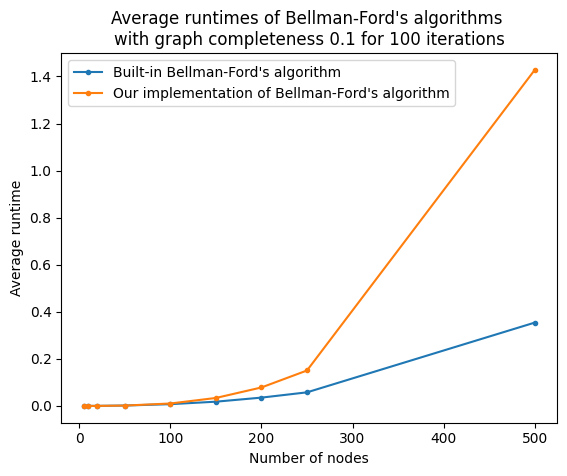

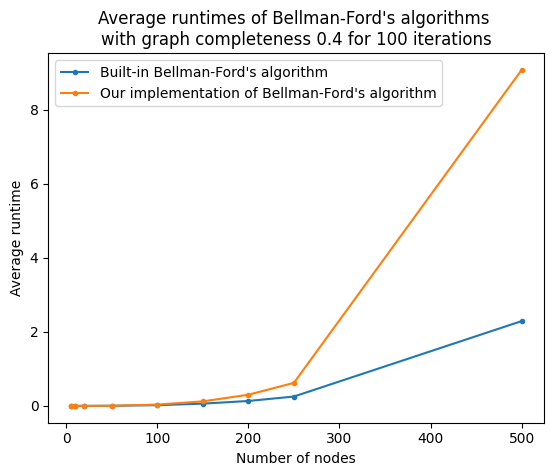

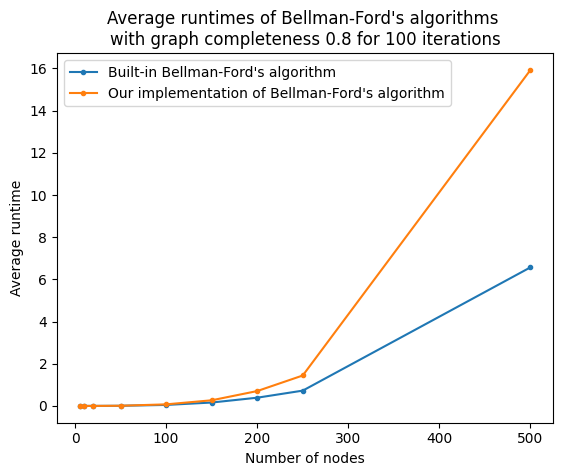

In [6]:
for completeness in COMPLETENESSES:
    plt.plot(NUM_OF_NODES, time_bf_nx[completeness], label="Built-in Bellman-Ford's algorithm", marker='.')
    plt.plot(NUM_OF_NODES, time_bf_our[completeness], label="Our implementation of Bellman-Ford's algorithm", marker='.')
    plt.xlabel('Number of nodes')
    plt.ylabel('Average runtime')
    plt.title(f"Average runtimes of Bellman-Ford's algorithms \nwith graph completeness {completeness} for {NUM_OF_ITERATIONS} iterations")
    plt.legend()
    plt.show()

### NetworkX Floyd-Warshall algorithm

In [3]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Negative cycle detected


### Our Floyd-Warshall algorithm

Варто зазначити, що наша імплементація Флойд-Воршала трохи відрізнається від тої, що у бібліотеці networkx, у нашій ми кожен раз робимо перевірку на від'ємних цикл і при його присутності зразу піднімаємо ексепшин і призупиняємо алгоритм.

In [7]:
def floyd_warshall(graph):
    nodes = list(graph.nodes)
    adj = dict(graph.adjacency())

    dists = {u: {v: float('inf') for v in nodes} for u in nodes}
    preds = {u: {v: None for v in nodes if v != u} for u in nodes}

    for u in nodes:
        for v, weight in adj[u].items():
            dists[u][v] = weight['weight']
            preds[u][v] = u
        dists[u][u] = 0

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dists[i][j] > dists[i][k] + dists[k][j]:
                    dists[i][j] = dists[i][k] + dists[k][j]
                    preds[i][j] = preds[k][j]
                if i == j and dists[i][j] < 0:
                    raise Exception

    return preds, dists

try:
    pred, dist = floyd_warshall(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Negative cycle detected


---

Наступні 3 блоки коду тестують нашу і networkx імплементацію алгортму Белмена-Форда і показують графіки порівняння їх виконання для 0.1, 0.4 і 0.8 рівнів заповнень і для 5, 10, 20, 50, 100, 150, 200 і 250 кількості вершин 100 разів.

In [13]:
import time
from tqdm import tqdm

COMPLETENESSES = (0.1, 0.4, 0.8)
NUM_OF_ITERATIONS = 100
NUM_OF_NODES = (5, 10, 20, 50, 100, 150, 200, 250)

In [14]:
time_fw_our = {}
time_fw_nx = {}
for completeness in COMPLETENESSES:
    time_list_our = []
    time_list_nx = []
    for nodes_num in NUM_OF_NODES:
        time_taken_our = 0
        time_taken_nx = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(nodes_num, completeness, False)
            
            try:
                start = time.time()
                floyd_warshall(G)
            except:
                pass
            finally:
                end = time.time()
                time_taken_our += end - start

            try:
                start = time.time()
                floyd_warshall_predecessor_and_distance(G)
            except:
                pass
            finally:
                end = time.time()
                time_taken_nx += end - start

        avg_time_our = time_taken_our / NUM_OF_ITERATIONS
        avg_time_nx = time_taken_nx / NUM_OF_ITERATIONS
        time_list_our.append(avg_time_our)
        time_list_nx.append(avg_time_nx)
        print(f'Our average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
        print(f'NetworkX average time per iteration: {avg_time_nx} seconds for {nodes_num=} with {completeness=}')
    time_fw_our[completeness] = time_list_our
    time_fw_nx[completeness] = time_list_nx
    print()
print(time_fw_our)
print(time_fw_nx)

100%|██████████| 100/100 [00:00<00:00, 12325.68it/s]


Our average time per iteration: 2.752065658569336e-05 seconds for nodes_num=5 with completeness=0.1
NetworkX average time per iteration: 3.129482269287109e-05 seconds for nodes_num=5 with completeness=0.1


100%|██████████| 100/100 [00:00<00:00, 2566.41it/s]


Our average time per iteration: 0.00017932891845703124 seconds for nodes_num=10 with completeness=0.1
NetworkX average time per iteration: 0.00016336679458618165 seconds for nodes_num=10 with completeness=0.1


100%|██████████| 100/100 [00:00<00:00, 620.90it/s]


Our average time per iteration: 0.000868978500366211 seconds for nodes_num=20 with completeness=0.1
NetworkX average time per iteration: 0.0006564903259277344 seconds for nodes_num=20 with completeness=0.1


100%|██████████| 100/100 [00:02<00:00, 46.32it/s]


Our average time per iteration: 0.012477328777313232 seconds for nodes_num=50 with completeness=0.1
NetworkX average time per iteration: 0.008626387119293213 seconds for nodes_num=50 with completeness=0.1


100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Our average time per iteration: 0.08957507133483887 seconds for nodes_num=100 with completeness=0.1
NetworkX average time per iteration: 0.058075118064880374 seconds for nodes_num=100 with completeness=0.1


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Our average time per iteration: 0.2947740602493286 seconds for nodes_num=150 with completeness=0.1
NetworkX average time per iteration: 0.19023484468460083 seconds for nodes_num=150 with completeness=0.1


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Our average time per iteration: 0.6891650581359863 seconds for nodes_num=200 with completeness=0.1
NetworkX average time per iteration: 0.4483979296684265 seconds for nodes_num=200 with completeness=0.1


100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


Our average time per iteration: 1.3234094643592835 seconds for nodes_num=250 with completeness=0.1
NetworkX average time per iteration: 0.8500951504707337 seconds for nodes_num=250 with completeness=0.1



100%|██████████| 100/100 [00:00<00:00, 17038.93it/s]


Our average time per iteration: 1.8944740295410155e-05 seconds for nodes_num=5 with completeness=0.4
NetworkX average time per iteration: 2.1653175354003905e-05 seconds for nodes_num=5 with completeness=0.4


100%|██████████| 100/100 [00:00<00:00, 3800.70it/s]


Our average time per iteration: 0.0001197671890258789 seconds for nodes_num=10 with completeness=0.4
NetworkX average time per iteration: 0.00010353326797485352 seconds for nodes_num=10 with completeness=0.4


100%|██████████| 100/100 [00:00<00:00, 624.33it/s]


Our average time per iteration: 0.0008386087417602539 seconds for nodes_num=20 with completeness=0.4
NetworkX average time per iteration: 0.0006303906440734864 seconds for nodes_num=20 with completeness=0.4


100%|██████████| 100/100 [00:02<00:00, 49.14it/s]


Our average time per iteration: 0.011604220867156982 seconds for nodes_num=50 with completeness=0.4
NetworkX average time per iteration: 0.008017113208770752 seconds for nodes_num=50 with completeness=0.4


100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Our average time per iteration: 0.08746591567993164 seconds for nodes_num=100 with completeness=0.4
NetworkX average time per iteration: 0.05613471746444702 seconds for nodes_num=100 with completeness=0.4


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Our average time per iteration: 0.28379281759262087 seconds for nodes_num=150 with completeness=0.4
NetworkX average time per iteration: 0.18322404384613036 seconds for nodes_num=150 with completeness=0.4


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Our average time per iteration: 0.6659349012374878 seconds for nodes_num=200 with completeness=0.4
NetworkX average time per iteration: 0.4324226975440979 seconds for nodes_num=200 with completeness=0.4


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


Our average time per iteration: 1.2682346844673156 seconds for nodes_num=250 with completeness=0.4
NetworkX average time per iteration: 0.8120386338233948 seconds for nodes_num=250 with completeness=0.4



100%|██████████| 100/100 [00:00<00:00, 17176.40it/s]


Our average time per iteration: 1.833677291870117e-05 seconds for nodes_num=5 with completeness=0.8
NetworkX average time per iteration: 2.1364688873291015e-05 seconds for nodes_num=5 with completeness=0.8


100%|██████████| 100/100 [00:00<00:00, 3471.73it/s]


Our average time per iteration: 0.00011736631393432617 seconds for nodes_num=10 with completeness=0.8
NetworkX average time per iteration: 0.00011558771133422852 seconds for nodes_num=10 with completeness=0.8


100%|██████████| 100/100 [00:00<00:00, 614.29it/s]


Our average time per iteration: 0.0008144688606262207 seconds for nodes_num=20 with completeness=0.8
NetworkX average time per iteration: 0.0006248164176940918 seconds for nodes_num=20 with completeness=0.8


100%|██████████| 100/100 [00:02<00:00, 48.15it/s]


Our average time per iteration: 0.011683661937713623 seconds for nodes_num=50 with completeness=0.8
NetworkX average time per iteration: 0.007849693298339844 seconds for nodes_num=50 with completeness=0.8


100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Our average time per iteration: 0.0846528959274292 seconds for nodes_num=100 with completeness=0.8
NetworkX average time per iteration: 0.055453970432281494 seconds for nodes_num=100 with completeness=0.8


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Our average time per iteration: 0.27083760499954224 seconds for nodes_num=150 with completeness=0.8
NetworkX average time per iteration: 0.17534886360168456 seconds for nodes_num=150 with completeness=0.8


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Our average time per iteration: 0.6500539422035218 seconds for nodes_num=200 with completeness=0.8
NetworkX average time per iteration: 0.4121284985542297 seconds for nodes_num=200 with completeness=0.8


100%|██████████| 100/100 [03:24<00:00,  2.04s/it]

Our average time per iteration: 1.2318028259277343 seconds for nodes_num=250 with completeness=0.8
NetworkX average time per iteration: 0.7889561939239502 seconds for nodes_num=250 with completeness=0.8

{0.1: [2.752065658569336e-05, 0.00017932891845703124, 0.000868978500366211, 0.012477328777313232, 0.08957507133483887, 0.2947740602493286, 0.6891650581359863, 1.3234094643592835], 0.4: [1.8944740295410155e-05, 0.0001197671890258789, 0.0008386087417602539, 0.011604220867156982, 0.08746591567993164, 0.28379281759262087, 0.6659349012374878, 1.2682346844673156], 0.8: [1.833677291870117e-05, 0.00011736631393432617, 0.0008144688606262207, 0.011683661937713623, 0.0846528959274292, 0.27083760499954224, 0.6500539422035218, 1.2318028259277343]}
{0.1: [3.129482269287109e-05, 0.00016336679458618165, 0.0006564903259277344, 0.008626387119293213, 0.058075118064880374, 0.19023484468460083, 0.4483979296684265, 0.8500951504707337], 0.4: [2.1653175354003905e-05, 0.00010353326797485352, 0.0006303906440734

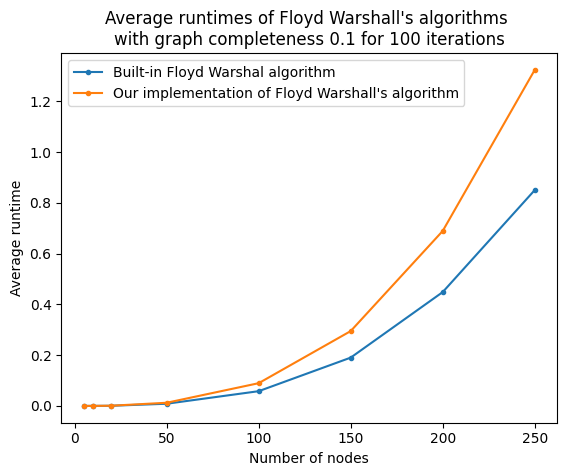

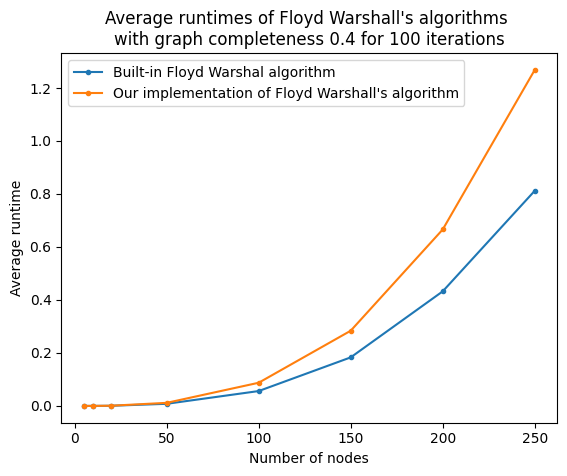

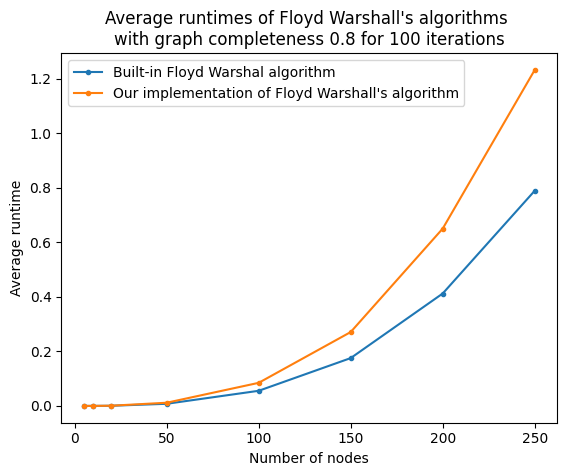

In [15]:
for completeness in COMPLETENESSES:
    plt.plot(NUM_OF_NODES, time_fw_nx[completeness], label="Built-in Floyd Warshal algorithm", marker='.')
    plt.plot(NUM_OF_NODES, time_fw_our[completeness], label="Our implementation of Floyd Warshall's algorithm", marker='.')
    plt.xlabel('Number of nodes')
    plt.ylabel('Average runtime')
    plt.title(f"Average runtimes of Floyd Warshall's algorithms \nwith graph completeness {completeness} for {NUM_OF_ITERATIONS} iterations")
    plt.legend()
    plt.show()

Як раніше ми казали, наша імплементація алгоритму зупиняє алгоритм при присутності від'ємного циклу, тож у функції для генерування графів ми вирішили модифікувати одне число для того щоб від'ємних ваг не було і тестили наші функції так. Отож видно що наша імплементація є повільніша ніж у networkx і ця різниця у часі залишається маєже одинаковою для різних значень заповненості і збільшується при збільшені кількості вершин у графі.

## Task 2. Decision Tree Classifier 

In [21]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [22]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [23]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [24]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

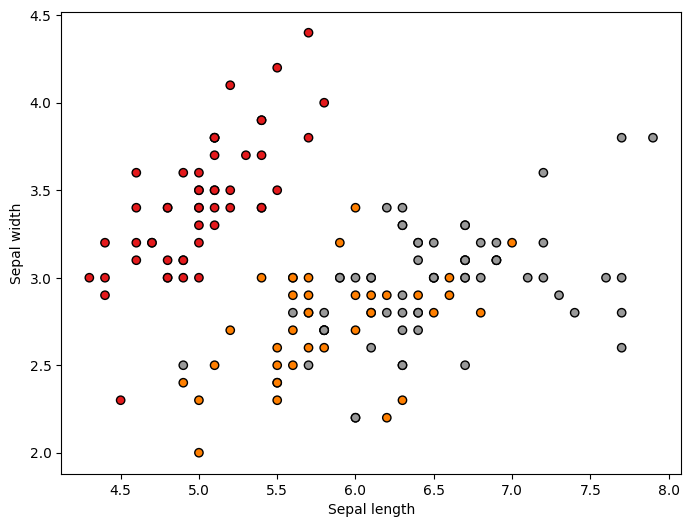

In [25]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [26]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [27]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [28]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [29]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

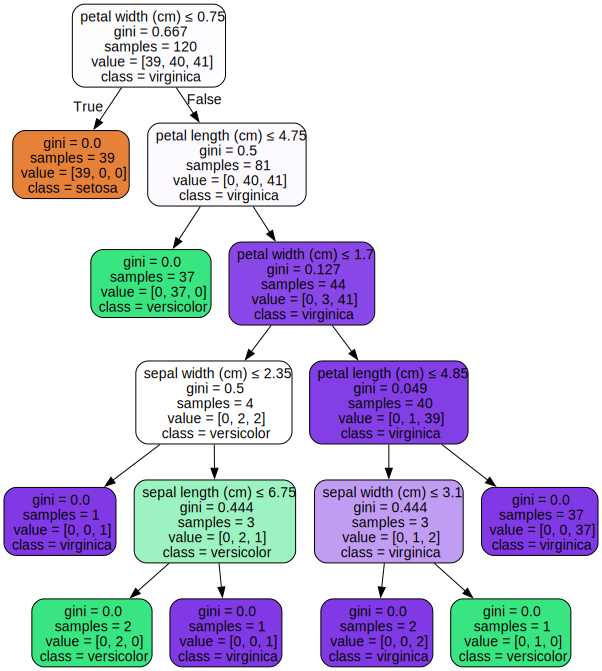

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [31]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [32]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [33]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [34]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [35]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [36]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [37]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size


    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass

In [38]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)